## Decision Tree: Branch Analyses

1. Reporting Year (Year 0 - baseline)
2. TTC Tree cover
3. Land Use
4. Strategy
5. Imagery or site accessibility

### General Notes
- inactive projects include: africorp-intl, divine-bamboo-group, germark, poel, s3d-niger (7 total in cohort 1)

### Decisions
- An "open" or "closed" designation was assigned at the project level based on the proportion of sites that fell the into open/closed category.
- Project names that did not align were dropped.
- ttc NA - sites without TTC % were dropped. This occurs due to missing TTC tiles, eventually we will have data. 
- Sites where planting occurs in 2025 were dropped. TODO: Check the other sites in the prj.
- What does imagery % represent and what is a workable threshold? Does it represent coverage for the polygon or wider AOI?
- plant_start - date that planting is started is available by site, so would have to aggregate for a project. Does it make sense to do the first date of planting?


**Notes on datasets**
- `target_sys` in ttc refers to the current land use (used for error calcs)
- when merging ttc and ft_polys using 3 keys - project name, site name and polygon name - there are some duplicates. It seems all values are the same except the slope and aspect stats. Not using these columns for now so dropping.

**Next**
- build y3 tree
- distributed vs concentrated assignment
- pull in code for imagery branch
- create params.yaml
- move to scripts (cleaning_combine.py, decision_tree.py, visuals.py)
- list potential branches to build (aspect, slope, etc.)




In [37]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import math

# Check alignment

In [3]:
# new polygon data as of 8/14/24
shp = gpd.read_file("../data/all_projects_TM_081424")
ttc_raw = pd.read_excel('../data/ttc_baseline_062024.xlsx')
ft_poly = pd.read_csv('../data/features_polygon_071824.csv')
display(shp.shape, ttc_raw.shape, ft_poly.shape)
display(shp.shape[0] - ft_poly.shape[0])

(13017, 7)

(11670, 19)

(13055, 11)

-38

In [4]:
# compare project, poly and site names across shp and csv
shp_prjlist = list(set(shp.Project))
ft_prjlist = list(set(ft_poly.Project))
shp_polylist = list(set(shp.poly_name))
ft_polylist = list(set(ft_poly.poly_name))
shp_sitelist = list(set(shp.SiteName))
ft_sitelist = list(set(ft_poly.SiteName))
diff_prj = [i for i in ft_prjlist if i not in shp_prjlist]
diff_poly = [i for i in ft_polylist if i not in shp_polylist]
diff_site = [i for i in ft_sitelist if i not in shp_sitelist]

diff_prj, diff_poly, diff_site

(['nguni'],
 ['Reforestation Project\xa010', 'koko Regeneration site'],
 ['Reforestation Project\xa0',
  'Kikandwa',
  'Bbambula',
  'koko Regeneration site',
  'Namwene',
  'Main_Gate'])

In [5]:
# how many polys within the missing sites?
site_df = ft_poly[ft_poly.SiteName.isin(['Bbambula',
                              'Reforestation Project\xa0',
                              'Main_Gate',
                              'koko Regeneration site',
                              'Namwene',
                              'Kikandwa'])]
site_df.shape

(54, 11)

In [6]:
# update ft_poly with shp to get updated target sys and practice values
ft_poly.rename(columns={'target_sys':'target_sys_og',
                     'practice':'practice_og'}, inplace=True)

ft_poly_new = pd.merge(ft_poly, 
                     shp[['Project', 'SiteName', 'poly_name','target_sys', 'practice']], 
                     how='inner', on=['Project', 'SiteName', 'poly_name'])
ft_poly_new = ft_poly_new.drop_duplicates()
ft_poly_new.shape

(13035, 13)

In [7]:
# check diff
ft_poly.shape[0] - ft_poly_new.shape[0]

20

In [8]:
# there are still some dups, likely bc of slope and aspect
columns_to_match = ['Project', 'SiteName', 'poly_name', 'plantstart', 'Area_ha']
dups = ft_poly_new.duplicated(subset=columns_to_match, keep=False)
display(dups.value_counts())
ft_poly_new = ft_poly_new.drop_duplicates(subset=columns_to_match)
ft_poly_new.shape

False    10981
True      2054
Name: count, dtype: int64

(11877, 13)

## Clean TTC

In [9]:
# clean ttc
ft_poly_new.columns = ft_poly_new.columns.map(lambda x: re.sub(' ', '_', x.lower().strip()))
to_keep = ['Percent Tree Cover 2020', 'Project', 'SiteName', 'poly_name']
drop_cols = [col for col in ttc_raw.columns if col not in to_keep]
ttc = ttc_raw[to_keep]
ttc.columns = ttc.columns.map(lambda x: re.sub(' ', '_', x.lower().strip()))
ttc = ttc.rename(columns={'percent_tree_cover_2020': 'ttc'})
print(f"Dropping {len(ttc[ttc['ttc'] == 'TTC_NA'])} null values for TTC")
ttc = ttc[ttc['ttc'] != 'TTC_NA']
ttc['ttc'] = ttc['ttc'].astype('float')
ttc['ttc'] = ttc['ttc'].round()
print(ttc['ttc'].min(), ttc['ttc'].max())

def classify_canopy(project):
    closed_canopy = (project['ttc'] > 40).sum()
    open_canopy = (project['ttc'] <= 40).sum()
    return 'open' if open_canopy > closed_canopy else 'closed'

# .transform() method in pandas is used to apply a function to a group or subset of a df and 
# return an aligned result, meaning the output has the same shape as the input.
ttc['canopy'] = ttc.groupby('project')['ttc'].transform(lambda x: classify_canopy(ttc[ttc['project'] == x.name]))

print(f"Total sites <=40% cover: {len(ttc[ttc.ttc <= 40])}")
print(f"Total sites >40% cover: {len(ttc[ttc.ttc > 40])}")
print(ttc.canopy.value_counts())

Dropping 221 null values for TTC
0.0 100.0
Total sites <=40% cover: 7808
Total sites >40% cover: 3641
canopy
open      8552
closed    2897
Name: count, dtype: int64


# Combine

In [11]:
inter = pd.merge(ft_poly_new, ttc, on=['project', 'sitename', 'poly_name'])
inter = inter.rename(columns={'available_baseline_images': 'baseline_img',
                              'available_ev_images':'ev_img'})

In [12]:
# manual cleaning of target_sys and practice
display(inter.practice.value_counts())

inter['target_sys'] = inter['target_sys'].str.replace(r'\briparian-area-or-wetland\b', 'wetland', regex=True)
inter['target_sys'] = inter['target_sys'].str.replace(r'\briparian-or-wetland\b', 'wetland', regex=True)
inter['target_sys'] = inter['target_sys'].str.replace(r'\bwoodlot-or-plantation\b', 'plantation', regex=True)

inter['practice'] = inter['practice'].replace({
    'direct-seedling':'direct-seeding',
    'direct-seeding,tree-planting':'tree-planting,direct-seeding',
    'assisted-natural-regeneration,tree-planting':'tree-planting,assisted-natural-regeneration',
    'assisted-natural-regeneration,direct-seeding':'direct-seeding,assisted-natural-regeneration',
})

inter['practice'] = inter['practice'].str.replace(r'\bassisted-natural-regeneration\b', 'ANR', regex=True)

practice
tree-planting                                                 10875
direct-seedling                                                 791
assisted-natural-regeneration                                   272
assisted-natural-regeneration,tree-planting,direct-seeding       92
assisted-natural-regeneration,tree-planting                      36
direct-seeding                                                    5
direct-seeding,tree-planting                                      4
direct-seeding,assisted-natural-regeneration                      4
tree-planting,assisted-natural-regeneration                       2
assisted-natural-regeneration,direct-seeding                      1
tree-planting,direct-seeding                                      1
Name: count, dtype: int64

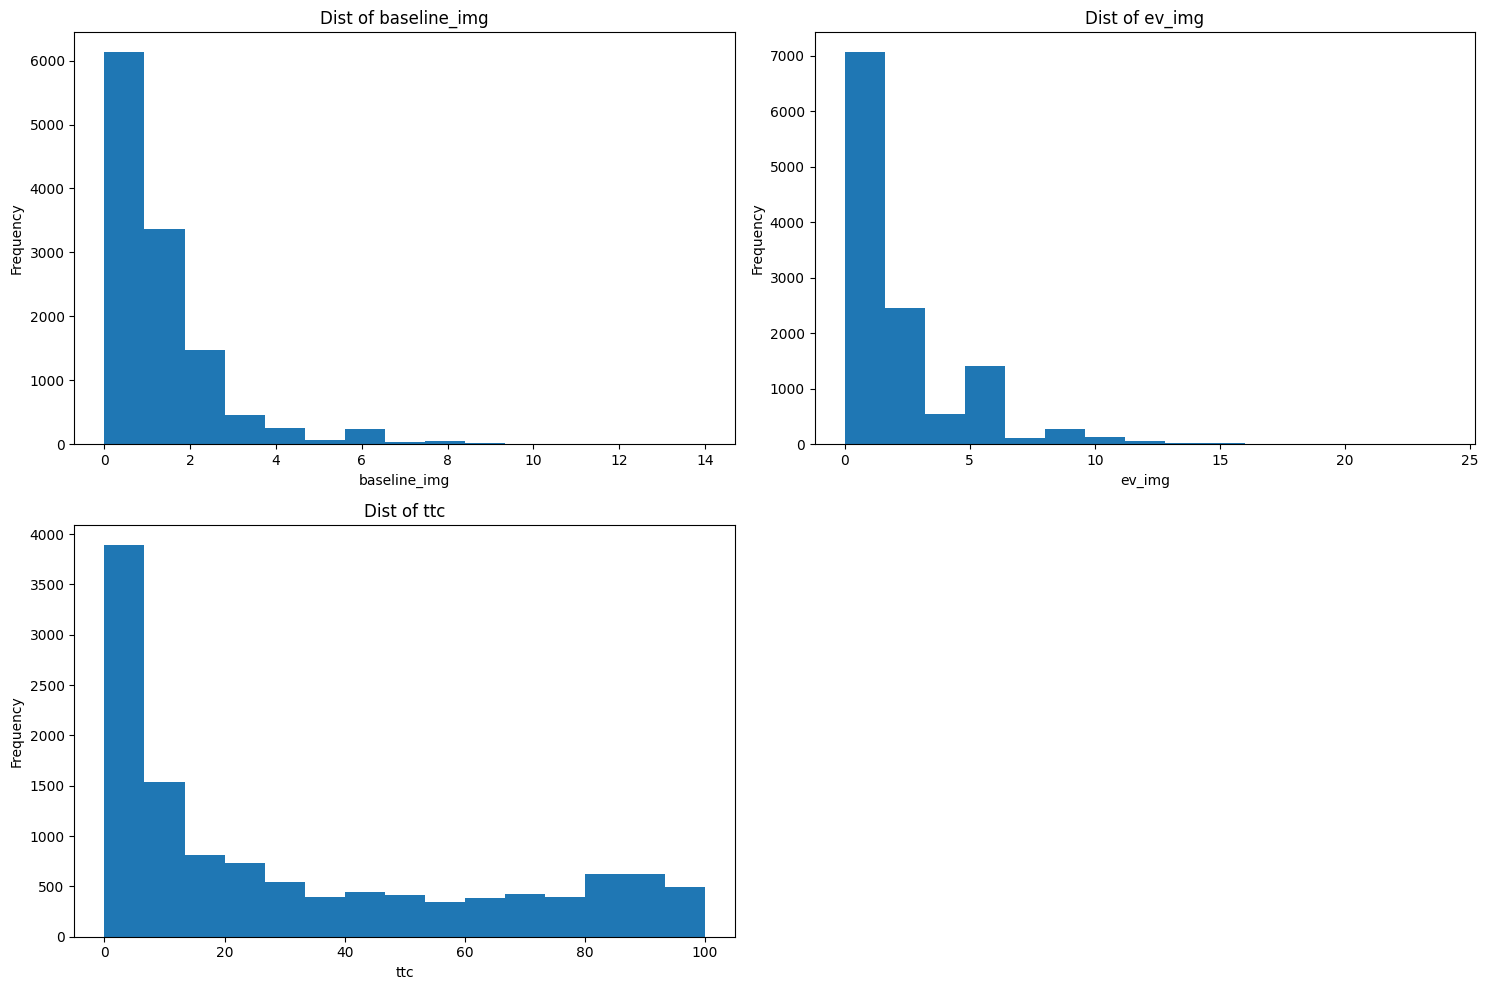

In [14]:
columns = ['baseline_img', 
          'ev_img',
          'ttc']
num_plots = len(columns)
fig, axes = plt.subplots(2, (num_plots // 2 + num_plots % 2), figsize=(15, 10))
axes = axes.flatten()
for i, col in enumerate(columns):
    inter[col].plot(kind='hist', bins=15, ax=axes[i], title=f'Dist of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
# Remove any empty subplots
for j in range(len(columns), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()

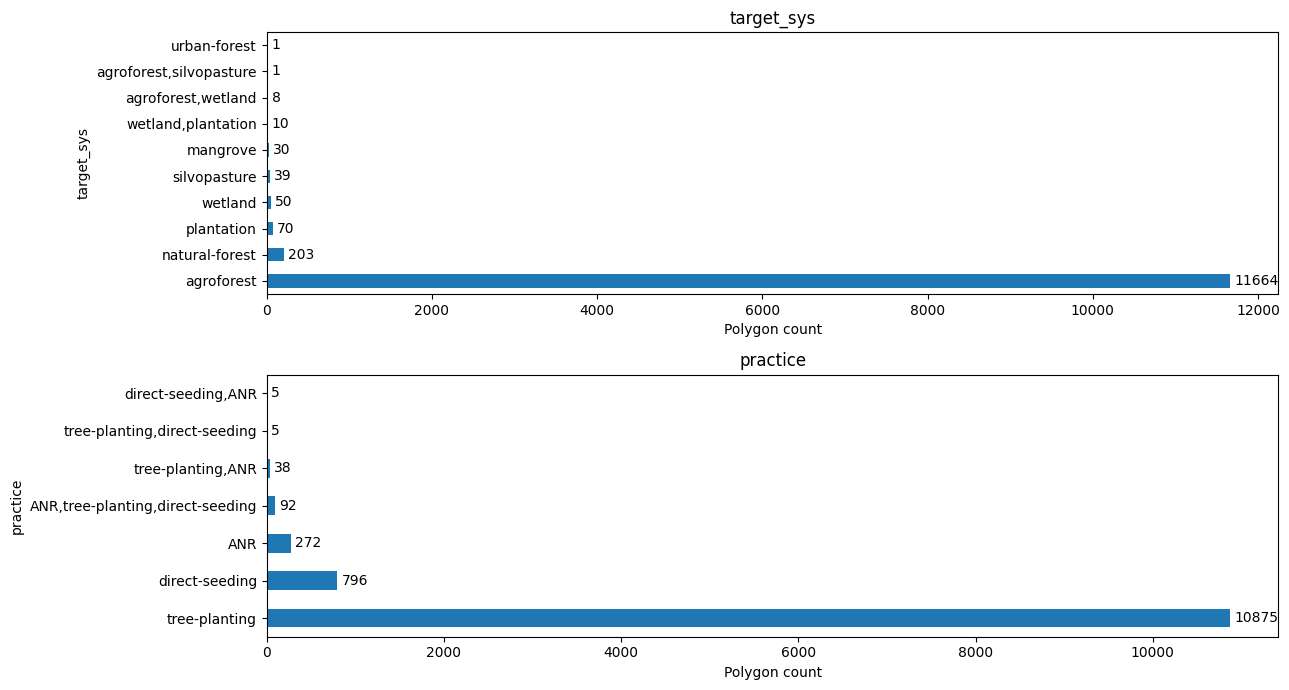

In [15]:
columns = ['target_sys', 'practice']
num_plots = len(columns)
fig, axes = plt.subplots(2, (num_plots // 2 + num_plots % 2), figsize=(13,7))
axes = axes.flatten()
for i, col in enumerate(columns):
    inter[col].value_counts().plot(kind='barh', ax=axes[i], title=f'{col}')
    axes[i].set_xlabel('Polygon count')
    axes[i].set_ylabel(col)
    for bars in axes[i].containers:
        axes[i].bar_label(bars,
                          label_type='edge', 
                          padding=3)
        
# Remove any empty subplots
for j in range(len(columns), len(axes)):
    fig.delaxes(axes[j])
    

plt.tight_layout()

## Create Trees
1. Tree Cover: >40% (closed) or <40% (open)
2. Land Use: Agroforest, Natural Forest, Woodlot/Plantation, Riparian Area/Wetland, Silvopasture, Mangrove, Natural Ecosystem, Urban Forest, mix
3. Practice: ANR, direct seeing, tree planting, mix

In [32]:
def year0(df):
    '''
    Assigns a remote or field verification method to every
    row in the input df, according baseline conditions (year0).
    Checks all rows have been assigned and prints method breakdown.
    Modifiable parameters include: 
        image requirements: Within 1 yr of planting date, there are 
        >=1 images available with <50% cloud cover
    
    Branch 1: at baseline, what is the canopy cover?
    Branch 2: what is the target land use?
    Branch 3: at baseline, how many images are available?

    TODO: determine how to handle polys w/ multiple target_sys
    '''

    ## BRANCH 1 ##
    open_ = df[df.canopy == 'open']
    closed_ = df[df.canopy == 'closed']

    ## BRANCH 2 ##
    open_landcovers = ['agroforestry', 'mangrove', 'wetland', 
                       'silvopasture', 'plantation', 'natural forest']
    closed_landcovers = ['plantation', 'natural forest']
    open_sys = open_[open_.target_sys.isin(open_landcovers)]
    closed_sys = closed_[closed_.target_sys.isin(closed_landcovers)]

    ## BRANCH 3 ##
    def image_availability(row):
        method = 'field' if row.baseline_img < 1 else 'remote'
        return method
    open_sys = open_sys.assign(method=open_sys.apply(image_availability, axis=1))
    closed_sys['method'] = 'field'
    
    comb = pd.concat([open_sys, closed_sys], ignore_index=True)
    assert not comb['method'].isnull().any(), "Some rows have not been assigned a method."
    method_counts = comb['method'].value_counts()
    method_breakdown = comb['method'].value_counts(normalize=True) * 100
    print("Method allocation:")
    for method, count in method_counts.items():
        percentage = method_breakdown[method]
        print(f"{method}: {count} projects ({percentage:.2f}%)")

    return comb

In [33]:
final = year0(inter)
final

Method allocation:
field: 92 projects (57.50%)
remote: 68 projects (42.50%)


,project,sitename,poly_name,plantstart,target_sys_og,practice_og,area_ha,baseline_img,ev_img,slope_stats,aspect_stats,target_sys,practice,ttc,canopy,method
0,ageref-cl,Diarrabakoko,Baba paulin,2023-09-14,riparian-area-or-wetland,Null,2.732027,0.0,2.0,"[{'min': 1272.792236328125, 'max': 8490.583007...","[{'min': 15.255118370056152, 'max': 341.565063...",wetland,tree-planting,3.0,open,field
1,asic,Tieneguebougou,AbdulayDiarra,2022-08-30,woodlot-or-plantation,Null,1.054624,1.0,2.0,"[{'min': 900.0, 'max': 4269.07470703125, 'mean...","[{'min': 108.43495178222656, 'max': 315.0, 'me...",plantation,tree-planting,20.0,open,remote
2,asic,Sirakoro,Kouloukou Diarra,2022-08-24,woodlot-or-plantation,Null,0.974594,2.0,8.0,"[{'min': 1423.02490234375, 'max': 6644.1704101...","[{'min': 8.130102157592773, 'max': 315.0, 'mea...",plantation,tree-planting,30.0,open,remote
3,asic,Sirado,Issa Diarra,2022-08-24,woodlot-or-plantation,Null,0.600088,1.0,2.0,"[{'min': 900.0, 'max': 4633.03369140625, 'mean...","[{'min': 18.434947967529297, 'max': 150.945388...",plantation,tree-planting,1.0,open,remote
4,asic,Sanamble,Woutiamba Diarra,2022-08-25,woodlot-or-plantation,Null,0.854225,0.0,3.0,"[{'min': 636.3961181640625, 'max': 6363.960937...","[{'min': 26.565052032470703, 'max': 315.0, 'me...",plantation,tree-planting,1.0,open,field
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,ope,OPE - Pandagichiza Site,Ng'wang'hosha Primary School,2023-08-11,Null,tree-planting,10.980713,1.0,0.0,"[{'min': 0.0, 'max': 7421.59033203125, 'mean':...","[{'min': 0.0, 'max': 354.8055725097656, 'mean'...",plantation,tree-planting,48.0,open,remote
156,ope,OPE - Pandagichiza Site,Mishepo Secondary ground01,2023-08-12,Null,tree-planting,1.966780,1.0,0.0,"[{'min': 1272.792236328125, 'max': 4970.412597...","[{'min': 71.56504821777344, 'max': 300.9637451...",plantation,tree-planting,46.0,open,remote
157,ope,OPE - Pandagichiza Site,Mishepo Secondary School ground02,2023-08-12,Null,tree-planting,0.934373,1.0,0.0,"[{'min': 0.0, 'max': 3244.99609375, 'mean': 16...","[{'min': 18.434947967529297, 'max': 270.0, 'me...",plantation,tree-planting,11.0,open,remote
158,recor,Mwendo,Mwendo Buffer 2,2023-12-14,riparian-area-or-wetland,Null,5.961955,1.0,7.0,"[{'min': 636.3961181640625, 'max': 11956.79687...","[{'min': 0.0, 'max': 357.273681640625, 'mean':...",wetland,tree-planting,24.0,open,remote


In [ ]:
def year3(df):
    '''
    Assigns a remote or field verification method to every
    row in the input df, according baseline conditions (year0).
    Checks all rows have been assigned and prints method breakdown.
    Modifiable parameters include: 
        image requirements: Within 1 yr of planting date, there are 
        >=1 images available with <50% cloud cover
    
    Branch 1: at baseline, what is the canopy cover?
    Branch 2: what is the target land use?
    Branch 3: at baseline, how many images are available?

    TODO: determine how to handle polys w/ multiple target_sys
    '''

    ## BRANCH 1 ##
    open_ = df[df.canopy == 'open']
    closed_ = df[df.canopy == 'closed']

    ## BRANCH 2 ##
    open_landcovers = ['agroforestry', 'mangrove', 'wetland', 
                       'silvopasture', 'plantation', 'natural forest']
    closed_landcovers = ['plantation', 'natural forest']
    open_sys = open_[open_.target_sys.isin(open_landcovers)]
    closed_sys = closed_[closed_.target_sys.isin(closed_landcovers)]

    ## BRANCH 3 ##
    def image_availability(row):
        method = 'field' if row.baseline_img < 1 else 'remote'
        return method
    open_sys = open_sys.assign(method=open_sys.apply(image_availability, axis=1))
    closed_sys['method'] = 'field'
    
    comb = pd.concat([open_sys, closed_sys], ignore_index=True)
    assert not comb['method'].isnull().any(), "Some rows have not been assigned a method."
    method_counts = comb['method'].value_counts()
    method_breakdown = comb['method'].value_counts(normalize=True) * 100
    print("Method allocation:")
    for method, count in method_counts.items():
        percentage = method_breakdown[method]
        print(f"{method}: {count} projects ({percentage:.2f}%)")

    return comb

# Check Results

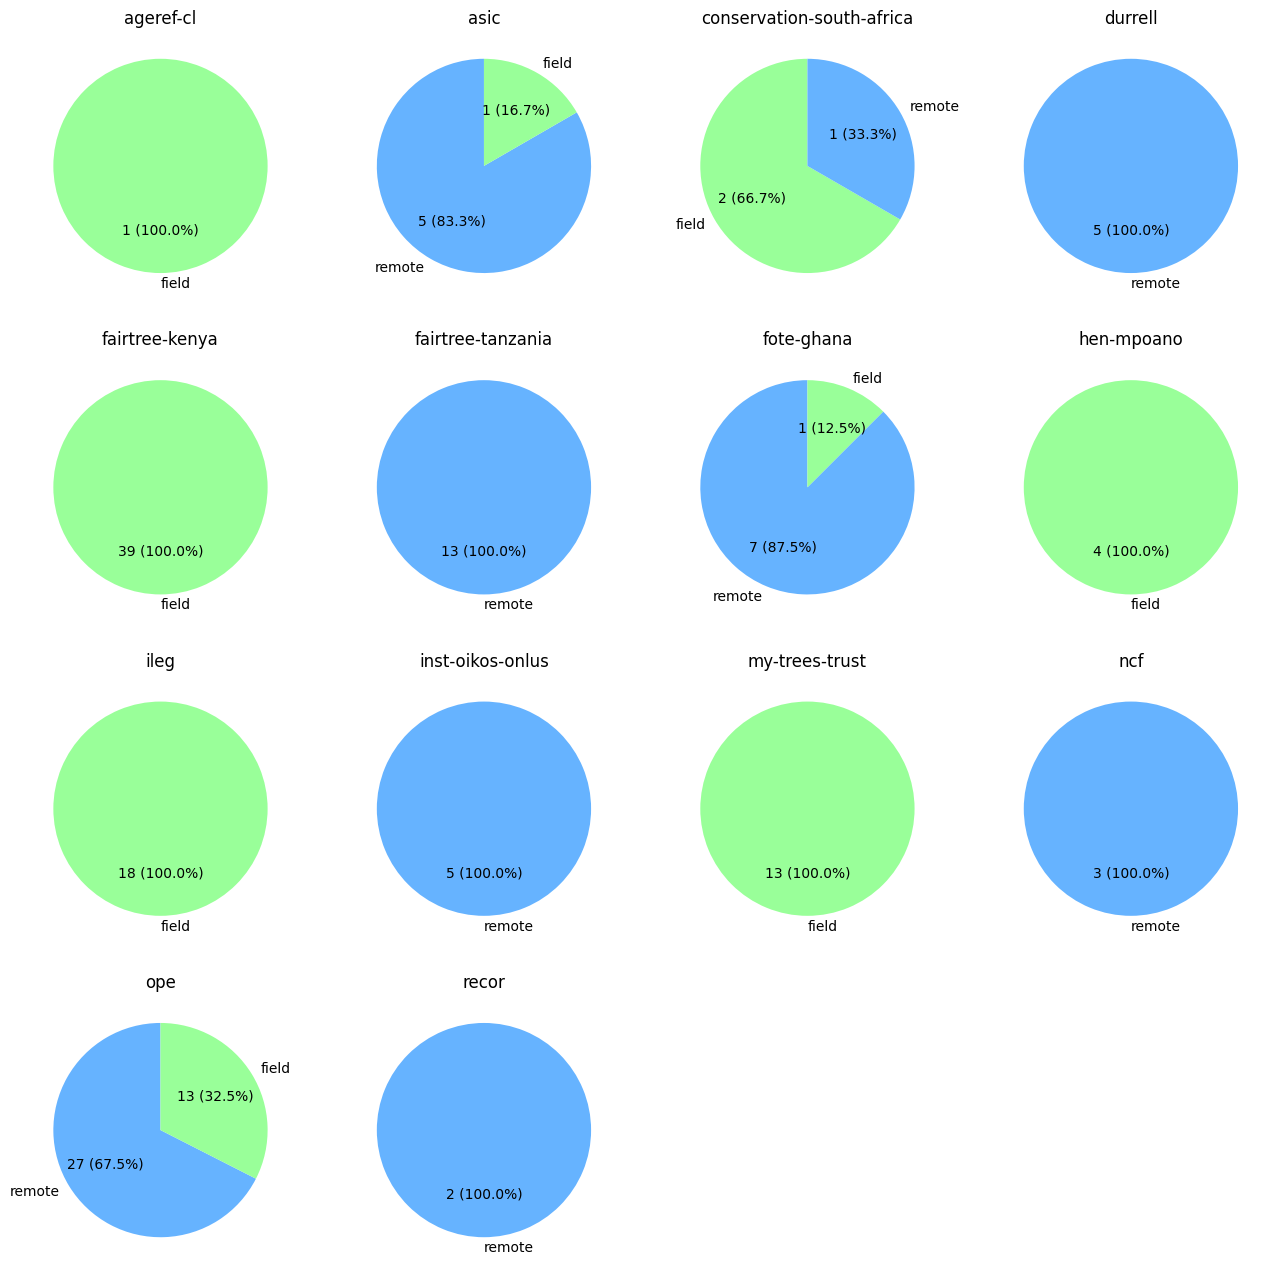

In [44]:
def method_piechart_perprj(df):
    """
    Iterates through each unique project in the 'project' column and creates a pie chart 
    illustrating the percentage breakdown of 'method' for each project.

    Parameters:
    df (pd.DataFrame): DataFrame containing the columns 'project' and 'method'.

    Returns:
    None: Displays pie charts for each project.
    """
    # Get the unique projects
    projects = df['project'].unique()
    num_projects = len(projects)
    
    # Calculate the number of rows and columns for subplots
    cols = math.ceil(math.sqrt(num_projects))
    rows = math.ceil(num_projects / cols)

    # Define a consistent color scheme for the methods
    color_dict = {
        'remote': '#66b3ff',  # Blue for remote
        'field': '#99ff99'    # Green for field
    }

    # Create a figure and axes for the subplots
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    
    # Flatten axes for easy iteration, in case of a single row or column
    axes = axes.flatten()
    
    # Loop through each project and plot
    for i, project in enumerate(projects):
        # Filter the dataframe for the current project
        project_df = df[df['project'] == project]

        # Get the method breakdown
        method_counts = project_df['method'].value_counts()

        # Create the color list based on the method counts
        colors = [color_dict[method] for method in method_counts.index]

        # Custom label function to show both count and percentage
        def autopct_format(pct):
            total = sum(method_counts)
            count = int(round(pct * total / 100.0))
            return f'{count} ({pct:.1f}%)'

        # Plot the pie chart in the respective subplot
        wedges, texts, autotexts = axes[i].pie(
            method_counts, 
            labels=method_counts.index, 
            autopct=autopct_format, 
            startangle=90, 
            colors=colors
        )
        
        axes[i].set_title(f"{project}", fontsize=12)

    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Show the plots
    plt.show()

method_piechart_perprj(final)

# Legacy

In [ ]:
    af_tp = open_[(open_.target_sys == 'agroforestry') & (open_.practice == 'tree-planting')]
    af_ds = open_[(open_.target_sys == 'agroforestry') & (open_.practice == 'direct-seeding')]
    af_anr = open_[(open_.target_sys == 'agroforestry') & (open_.practice == 'ANR')]
    mgr_tp = open_[(open_.target_sys == 'mangrove') & (open_.practice == 'tree-planting')]
    mgr_anr = open_[(open_.target_sys == 'mangrove') & (open_.practice == 'ANR')]
    nf_tp = open_[(open_.target_sys == 'natural forest') & (open_.practice == 'tree-planting')]
    nf_ds = open_[(open_.target_sys == 'natural forest') & (open_.practice == 'direct-seeding')]
    nf_anr = open_[(open_.target_sys == 'natural forest') & (open_.practice == 'ANR')]
    plant_tp = open_[(open_.target_sys == 'plantation') & (open_.practice == 'tree-planting')]
    wet_tp = open_[(open_.target_sys == 'wetland') & (open_.practice == 'tree-planting')]
    wet_anr = open_[(open_.target_sys == 'wetland') & (open_.practice == 'ANR')]
    silvo_tp =  & (open_.practice == 'tree-planting')]
    silvo_ds = open_[(open_.target_sys == 'silvopasture') & (open_.practice == 'direct-seeding')]
    silvo_anr = open_[(open_.target_sys == 'silvopasture') & (open_.practice == 'ANR')]
    plant_tp_closed = closed_[(closed_.target_sys == 'plantation') & (closed_.practice == 'tree-planting')]
    nf_tp_closed =  & (closed_.practice == 'tree-planting')]
    nf_ds_closed = closed_[(closed_.target_sys == 'natural forest') & (closed_.practice == 'direct-seeding')]
    nf_anr_closed = closed_[(closed_.target_sys == 'natural forest') & (closed_.practice == 'ANR')]

    af = open_[(open_.target_sys == 'agroforestry')]
    mgr = open_[(open_.target_sys == 'mangrove')]
    wet = open_[(open_.target_sys == 'wetland')]
    silvo = open_[(open_.target_sys == 'silvopasture')]
    plant_open = open_[(open_.target_sys == 'plantation')]
    nf_open = open_[(open_.target_sys == 'natural forest')]
    plant_closed = closed_[(closed_.target_sys == 'plantation')]
    nf_closed = closed_[(closed_.target_sys == 'natural forest')]

In [77]:
img_dir = '../data/imagery_availability/cohort1/'
imagery_files = os.listdir(img_dir)
imagery = []
for project in imagery_files:
    df = pd.read_csv(f"{img_dir}/{project}")
    sub_df = df[['Name', 
                 'properties.datetime',
                 'collection', 
                 'properties.eo:cloud_cover', 
                 'properties.off_nadir_avg']]
    sub_df = sub_df.assign(Project=project.replace('afr100_', '').replace('_imagery_availability.csv', ''))
    imagery.append(sub_df)
all_projects_df = pd.concat(imagery).reset_index()
all_projects_df = all_projects_df[['Project', 
                                   'Name', 
                                   'properties.datetime',
                                   'collection', 
                                   'properties.eo:cloud_cover',
                                   'properties.off_nadir_avg']]
all_projects_df = all_projects_df[~pd.isna(all_projects_df['Name'])]
all_projects_df.rename(columns={'Name':'poly_name'}, inplace=True)
all_projects_df.loc[:, 'properties.datetime'] = pd.to_datetime(all_projects_df['properties.datetime'], 
                                                               format='mixed').dt.normalize()
all_projects_df.loc[:, 'properties.datetime'] = all_projects_df['properties.datetime'].apply(lambda x: x.replace(tzinfo=None))

/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_59671/842933163.py:5: DtypeWarning: Columns (73,74,75) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"{img_dir}/{project}")


In [78]:
all_projects_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147348 entries, 0 to 147347
Data columns (total 6 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Project                    147348 non-null  object 
 1   poly_name                  147348 non-null  object 
 2   properties.datetime        147348 non-null  object 
 3   collection                 147348 non-null  object 
 4   properties.eo:cloud_cover  147348 non-null  float64
 5   properties.off_nadir_avg   147348 non-null  float64
dtypes: float64(2), object(4)
memory usage: 6.7+ MB


In [85]:
# create a master csv of all projects for img availability, elevation and sun
img_dir = 'imagery_availability/cohort1/'
csv_list = listdir(img_dir)
csv_list = [re.split(r'_', file)[1] for file in csv_list if file.endswith('.csv')]
master_csv = pd.DataFrame()
for i in csv_list[0:1]:
    i = 'bccp'
    df = pd.read_csv(f'{img_dir}afr100_{i}_imagery_availability.csv')
    df = df[['id', 
             'collection', 
             'properties.datetime',
             'properties.eo:cloud_cover',
             'properties.collect_time_end',
             'properties.collect_time_start',
#              'properties.off_nadir_avg', 
#              'properties.off_nadir_end',
#              'properties.off_nadir_max', 
#              'properties.off_nadir_min',
#              'properties.view:sun_elevation_max',
#              'properties.view:sun_elevation_min',
            ]]
    dt_cols = ['properties.datetime',
                 'properties.collect_time_end',
                 'properties.collect_time_start',
               ]
    df[dt_cols] = df[dt_cols].apply(pd.to_datetime, errors='coerce')
    # Ensure 'properties.datetime' column is timezone-naive
    df['properties.datetime'] = df['properties.datetime'].apply(lambda x: x.replace(tzinfo=None) if x.tzinfo else x)
    planting_date = ttc[ttc.project == i]['plantstart']
#    df['baseline_imgs'] = df['properties.datetime'].apply(lambda x: 1 if planting_date <= x <= planting_date + timedelta(days=365) else 0)
#     df['baseline_cloud_free'] = len(df[(df['baseline_imgs'] == 1) & (df['properties.eo:cloud_cover'] == 1)])
#     agg_data = {
#         'project_name': i,
#         'total_imgs': len(df),
#         'total_cloud_free': sum(df['properties.eo:cloud_cover']),
#         'baseline_imgs': sum(df['baseline_imgs']),
#         'baseline_cloud_free':sum(df['baseline_cloud_free']),
#                              }
# #         'early_imgs':,
# #         'early_cloud_free',
# #         'endline_imgs':,
# #         'endline_cloud_free':,
#     agg_table = pd.DataFrame([agg_data])
    

In [15]:
ft_raw.columns = ft_raw.columns.map(lambda x: re.sub(' ', '_', x.lower().strip()))
ft = ft_raw[['project', 'area_ha', 'percent_imagery_coverage', 'agroforestry',
       'tree_planting', 'assisted_natural_regeneration', 'enrichment_planting',
       'reforestation', 'direct_propagules_planting', 'natural_regeneration',
       'applied_nucleation/tree_island', 'woodlot', 'direct_seeding',
       'mangrove_tree_restoration', 'natural_forest', 'riparian_restoration']]
ft = ft.rename(columns={'mangrove_tree_restoration': 'mangrove',
                    'riparian_restoration':'riparian'})

## land use
land_use = ['agroforestry',
            'woodlot',
            'mangrove', 
            'natural_forest', 
            'riparian']

for col in land_use:
    ft[col] = ft[col].apply(lambda x: 1 if x > 0 else x)

## planting strategy
strategy = ['direct_seeding', 
            'tree_planting', 
            'assisted_natural_regeneration', 
            'natural_regeneration', # change this
            'enrichment_planting',
            'direct_propagules_planting',
            'applied_nucleation/tree_island',
            'reforestation',
           ]

for col in strategy:
    ft[col] = ft[col].apply(lambda x: 1 if x > 0 else x)